In [39]:
import sys
from datetime import datetime
import pandas as pd
import numpy as np
sys.path.append("..")
from pathlib import Path
from typing import Dict, Union, List
import csv
from cvss import CVSS3

## Read data

In [40]:
def read_cve_vector_predictions(filepath) -> Dict:
    cvss_dict = {}
    with open(filepath, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            cvss_dict[row['cve']] = row['predicted_vector']
    return cvss_dict

In [41]:
cve_vector_pred_filepath = Path(".").resolve().parent / "data" / "cve_vector_predictions_all.csv"
cve_vector_predictions = read_cve_vector_predictions(cve_vector_pred_filepath)

In [42]:
import json

def load_json_file(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print("The file was not found at the specified path.")
        return None
    except json.JSONDecodeError:
        print("The file is not a valid JSON file.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [43]:
def parse_cvss_vector(cvss_vector: str) -> Dict:
    mapping = {
        "AV": ("attack_vector", {"N": "NETWORK", "A": "ADJACENT", "L": "LOCAL", "P": "PHYSICAL"}),
        "AC": ("attack_complexity", {"L": "LOW", "H": "HIGH"}),
        "PR": ("privileges_required", {"N": "NONE", "L": "LOW", "H": "HIGH"}),
        "UI": ("user_interaction", {"N": "NONE", "R": "REQUIRED"}),
        "S": ("scope", {"U": "UNCHANGED", "C": "CHANGED"}),
        "C": ("confidentiality_impact", {"N": "NONE", "L": "LOW", "H": "HIGH"}),
        "I": ("integrity_impact", {"N": "NONE", "L": "LOW", "H": "HIGH"}),
        "A": ("availability_impact", {"N": "NONE", "L": "LOW", "H": "HIGH"})
    }

    components = cvss_vector.split("/")
    c = CVSS3(cvss_vector)
    extracted_data = {}

    for component in components[1:]:
        key, value = component.split(":")
        full_key, value_mapping = mapping[key]
        extracted_data[full_key] = value_mapping[value]

    extracted_data.update({
        "cvssv3_version": components[0],
        "vector_string": cvss_vector,
        "base_score": c.scores()[0],
        "base_severity": c.severities()[0].upper()
    })
    
    return extracted_data

def extract_cvssv3_details(data: Dict) -> Dict:
    cvssv3 = data["impact"]["baseMetricV3"]["cvssV3"]

    extracted_data = {
        "cvssv3_version": cvssv3["version"],
        "vector_string": cvssv3["vectorString"],
        "attack_vector": cvssv3["attackVector"],
        "attack_complexity": cvssv3["attackComplexity"],
        "privileges_required": cvssv3["privilegesRequired"],
        "user_interaction": cvssv3["userInteraction"],
        "scope": cvssv3["scope"],
        "confidentiality_impact": cvssv3["confidentialityImpact"],
        "integrity_impact": cvssv3["integrityImpact"],
        "availability_impact": cvssv3["availabilityImpact"],
        "base_score": cvssv3["baseScore"],
        "base_severity": cvssv3["baseSeverity"]
    }

    return extracted_data


def contains_basemetricv3(cve_entry) -> bool:
    impact = cve_entry.get("impact", {})
    return "baseMetricV3" in impact

def count_each_tag_in_references(data) -> Dict[str, int]:
    # Extracting references
    references = data["cve"]["references"]["reference_data"]

    # Counting tags
    tag_counts: Dict[str, int] = {}
    for reference in references:
        for tag in reference["tags"]:
            ref_tag = "ref_" + tag.lower().replace(" ", "_")
            if ref_tag in tag_counts:
                tag_counts[ref_tag] += 1
            else:
                tag_counts[ref_tag] = 1

    return tag_counts

def extract_data_from_cve(cve_entry, cve_vector_predictions) -> Union[None, Dict]:
    tag_counts = count_each_tag_in_references(cve_entry)
    cve_id = cve_entry["cve"]["CVE_data_meta"]["ID"]
    description = cve_entry["cve"]["description"]["description_data"][0]["value"]

    if contains_basemetricv3(cve_entry):
        cvss = extract_cvssv3_details(cve_entry)
    elif cve_id in cve_vector_predictions:
        cvss_vector = cve_vector_predictions.get(cve_id)
        cvss = parse_cvss_vector(cvss_vector)
    else:
        return None

    # Extracting published and last modified dates
    cvss["published_date"] = cve_entry["publishedDate"]
    cvss["last_modified_date"] = cve_entry["lastModifiedDate"]

    return {"cve_id": cve_id, **tag_counts, **cvss}

In [44]:
nvd_filepath = Path(".").resolve().parent / "NVD_jsons"

cve_data = []

def process_cve_entries(nvd_filepath) -> List:
    for file_path in nvd_filepath.iterdir():
        corpus = load_json_file(file_path)
        for cve_entry in corpus["CVE_Items"]:
            extracted_data = extract_data_from_cve(cve_entry, cve_vector_predictions)
            if extracted_data:
                cve_data.append(extracted_data)

    return cve_data


In [45]:
cve_data = process_cve_entries(nvd_filepath)

In [46]:
df = pd.DataFrame(cve_data)

In [47]:
df.select_dtypes("number").columns

Index(['ref_patch', 'ref_vendor_advisory', 'base_score',
       'ref_third_party_advisory', 'ref_not_applicable', 'ref_mailing_list',
       'ref_exploit', 'ref_permissions_required', 'ref_vdb_entry',
       'ref_product', 'ref_release_notes', 'ref_us_government_resource',
       'ref_mitigation', 'ref_issue_tracking', 'ref_broken_link',
       'ref_technical_description', 'ref_press/media_coverage',
       'ref_url_repurposed', 'ref_tool_signature'],
      dtype='object')

In [48]:
df.select_dtypes("object").columns

Index(['cve_id', 'cvssv3_version', 'vector_string', 'attack_vector',
       'attack_complexity', 'privileges_required', 'user_interaction', 'scope',
       'confidentiality_impact', 'integrity_impact', 'availability_impact',
       'base_severity', 'published_date', 'last_modified_date'],
      dtype='object')

## CVE vector assign

In [10]:
df = df.assign(**{
    component.split(':')[0]: np.where(
        df['cve_vector'] == 'NVD-CVE-vector-noinfo',
        np.nan,
        component.split(':')[1]
    )
    for component in df.loc[df['cve_vector'] != 'NVD-CVE-vector-noinfo', 'cve_vector']
    .str.replace('CVSS:3.1/', '')
    .str.split('/')
    .explode()
    .unique()
})

In [20]:
(df
 .query('description.str.contains("REJECT")')
 .description
 .iloc[1]
)

'** REJECT **  DO NOT USE THIS CANDIDATE NUMBER. ConsultIDs: none. Reason: The CNA or individual who requested this candidate did not associate it with any vulnerability during 2011. Notes: none.'

In [21]:
df.select_dtypes("string").columns

Index(['cve', 'cve_vector', 'description'], dtype='object')

## Preprocessing

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [65]:
num_cols = ['ref_vendor_advisory', 'base_score',
       'ref_broken_link', 'ref_us_government_resource', 'ref_mailing_list',
       'ref_not_applicable',
       'ref_permissions_required', 'ref_issue_tracking', 'ref_release_notes',
       'ref_tool_signature', 'ref_technical_description', 'ref_product',
       'ref_mitigation', 'ref_press/media_coverage', 'ref_url_repurposed', 'age']


binary_cols = ["ref_exploit", "ref_vdb_entry", 'ref_third_party_advisory', 'ref_patch']


cat_cols = ['attack_vector', 'attack_complexity', 'privileges_required',
       'user_interaction', 'scope', 'confidentiality_impact',
       'integrity_impact', 'availability_impact']

In [66]:
def log_transform(x):
    return np.log(x + 1)


def custom_threshold(x):
    return (x > 0).astype(int)


def threshold_name(function_transformer, feature_names_in):
    return ["" + name for name in feature_names_in]


def create_preprocessing_pipeline(num_cols, cat_cols, log_pipe=False):
    if log_pipe:
        numeric_transformer = Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("log_transform", FunctionTransformer(log_transform, feature_names_out="one-to-one")),
            ("std_scale", StandardScaler())
        ])
    else:
        numeric_transformer = Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
            ("std_scale", StandardScaler())
        ])
    categorical_transformer = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    threshold_transformer = FunctionTransformer(custom_threshold, feature_names_out=threshold_name)

    preprocessing = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
            ("indicator", threshold_transformer, binary_cols)
        ],
        remainder="drop",
        sparse_threshold=0
    )
    return preprocessing

def create_pipeline(preprocessor, model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

In [67]:
create_preprocessing_pipeline(num_cols, cat_cols, log_pipe=False)

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scale',
                                                  StandardScaler())]),
                                 ['ref_vendor_advisory', 'base_score',
                                  'ref_broken_link',
                                  'ref_us_government_resource',
                                  'ref_mailing_list', 'ref_not_applicable',
                                  'ref_permissions_required',
                                  'ref_issue_tracking', 'ref_release_notes',
                                  'ref_too...
                                 ['attack_vector', 'attack_complexity',
                                  'privileges_required', 'user_interaction',
                                  'scope', 'confidentiality_impact',
                                  'integrity_impact', 'availability_impact']),
                                ('indicator',
                                 FunctionTransformer(feature_names_out=<function threshold_name at 0x17fbe9440>,
                                                     func=<function custom_threshold at 0x17fbe93a0>),
                                 ['ref_exploit', 'ref_vdb_entry',
                                  'ref_third_party_advisory', 'ref_patch'])])

## Binary prediction preparation

In [49]:
from src.utils import read_observations
from pathlib import Path
import dateparser

In [54]:
observations = pd.read_csv(Path.cwd().parent / "data" / "cve_observations.csv", parse_dates=["date"])

In [55]:
observations

,date,count,cve
0,2024-02-02,30797,CVE-2021-44228
1,2024-02-02,8938,CVE-2022-26134
2,2024-02-02,102,CVE-2018-19276
3,2024-02-02,102,CVE-2013-2135
4,2024-02-02,336,CVE-2018-11776
...,...,...,...
96458,2023-09-25,1,CVE-2023-35082
96459,2023-09-25,1,CVE-2022-24990
96460,2023-09-25,1,CVE-2021-41773
96461,2023-09-25,1,CVE-2017-15944


In [56]:
reference_date: datetime = dateparser.parse("2023/12/1")
horizon = 30

In [57]:
reference_date + pd.DateOffset(days=horizon)

Timestamp('2023-12-31 00:00:00')

In [81]:
def create_cve_exists_dataframe(observations_df, reference_date, horizon):
    target_date = reference_date + pd.DateOffset(days=horizon)
    # Filter dataframe for period
    filtered_df = observations_df[(observations_df['date'] > reference_date) & (observations_df['date'] <= target_date)]
    # Get unique CVEs in the observations dataframe
    unique_cves = observations_df['cve'].unique()
    # Initialize
    results = pd.DataFrame(unique_cves, columns=['cve'])
    results = results.assign(exists=lambda x: x['cve'].isin(filtered_df['cve']).astype(int))
    last_dates = filtered_df.groupby('cve')['date'].max().reset_index()
    last_dates.rename(columns={'date': 'last_observed_date'}, inplace=True)
    results = pd.merge(results, last_dates, on='cve', how='left')
    return results

def create_dataset(df: pd.DataFrame, observed_cves, reference_date):
    observed_df = df[df["cve_id"].isin(observed_cves)]
    not_observed_df = df[~df["cve_id"].isin(observed_cves)]

    data_without_counts = not_observed_df.sample(
        n=len(observed_df), random_state=16
    )

    data = pd.concat(
        [observed_df, data_without_counts], axis=0, ignore_index=True
    )
    data['published_date'] = pd.to_datetime(data['published_date']).dt.date
    data["age"] = (reference_date.date() - data['published_date']).apply(lambda x: x.days)
    return data.assign(exists=lambda x: x['cve_id'].isin(observed_cves).astype(int))


def generate_datasets(df, observations, initial_date, horizon, periods):
    datasets = []
    reference_date = dateparser.parse(initial_date)
    for _ in range(periods):
        result_df = create_cve_exists_dataframe(observations, reference_date, horizon)
        observed_cves = result_df.query('exists == 1')['cve']
        dataset = create_dataset(df, observed_cves, reference_date)
        datasets.append(dataset)
        reference_date += pd.DateOffset(days=horizon + 1)

    combined_dataset = pd.concat(datasets, ignore_index=True)
    return combined_dataset

data = generate_datasets(df, observations, initial_date='2023-04-29', horizon=30, periods=10)

In [74]:
reference_date: datetime = dateparser.parse('2023-04-29')
horizon = 30
periods = 10

for _ in range(periods):
    target_date = reference_date + pd.DateOffset(days=horizon)
    filtered_df = observations[(observations['date'] > reference_date) & (observations['date'] <= target_date)]
    unique_cves = observations['cve'].unique()
    results = pd.DataFrame(unique_cves, columns=['cve'])
    results = results.assign(exists=lambda x: x['cve'].isin(filtered_df['cve']).astype(int))

    print("Getting training set for period: ", reference_date, " - ", target_date)
    print("Unique number of CVEs for period: ", filtered_df.cve.nunique())
    print("Shape of DataFrame for period: ", filtered_df.shape)

    observed_cves = results.query('exists == 1')['cve'].values
    observed_df = df[df["cve_id"].isin(observed_cves)]
    print(observed_df.shape)

    reference_date += pd.DateOffset(days=horizon + 1)

    print("")

Getting training set for period:  2023-04-29 00:00:00  -  2023-05-29 00:00:00
Unique number of CVEs for period:  393
Shape of DataFrame for period:  (7238, 3)
(389, 33)

Getting training set for period:  2023-05-30 00:00:00  -  2023-06-29 00:00:00
Unique number of CVEs for period:  628
Shape of DataFrame for period:  (7779, 3)
(622, 33)

Getting training set for period:  2023-06-30 00:00:00  -  2023-07-30 00:00:00
Unique number of CVEs for period:  540
Shape of DataFrame for period:  (8214, 3)
(535, 33)

Getting training set for period:  2023-07-31 00:00:00  -  2023-08-30 00:00:00
Unique number of CVEs for period:  597
Shape of DataFrame for period:  (7833, 3)
(592, 33)

Getting training set for period:  2023-08-31 00:00:00  -  2023-09-30 00:00:00
Unique number of CVEs for period:  591
Shape of DataFrame for period:  (13207, 3)
(586, 33)

Getting training set for period:  2023-10-01 00:00:00  -  2023-10-31 00:00:00
Unique number of CVEs for period:  693
Shape of DataFrame for period:  

In [34]:
df.cve_id

0         CVE-2011-0001
1         CVE-2011-0002
2         CVE-2011-0003
3         CVE-2011-0004
4         CVE-2011-0005
              ...      
102443    CVE-2002-2442
102444    CVE-2002-2443
102445    CVE-2002-2444
102446    CVE-2002-2445
102447    CVE-2002-2446
Name: cve_id, Length: 102448, dtype: object

In [51]:
result = create_cve_exists_dataframe(observations, reference_date, horizon)
result.shape

(1225, 3)

In [76]:
data

,cve_id,ref_patch,ref_vendor_advisory,cvssv3_version,vector_string,attack_vector,attack_complexity,privileges_required,user_interaction,scope,...,ref_us_government_resource,ref_mitigation,ref_issue_tracking,ref_broken_link,ref_technical_description,ref_press/media_coverage,ref_url_repurposed,ref_tool_signature,age,exists
0,CVE-2021-1498,NaN,1.0,3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723,1
1,CVE-2021-1499,NaN,1.0,3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:N/I:L/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723,1
2,CVE-2021-20038,NaN,1.0,3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507,1
3,CVE-2021-20090,NaN,NaN,3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,730,1
4,CVE-2021-20124,NaN,NaN,3.1,CVSS:3.1/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:N/A:N,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,563,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12723,CVE-2018-8495,1.0,1.0,3.0,CVSS:3.0/AV:N/AC:H/PR:N/UI:R/S:U/C:H/I:H/A:H,NETWORK,HIGH,NONE,REQUIRED,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941,0
12724,CVE-2018-5487,1.0,1.0,3.0,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2080,0
12725,CVE-2016-9901,1.0,2.0,3.0,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:H/A:H,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2062,0
12726,CVE-2016-3582,1.0,1.0,3.0,CVSS:3.0/AV:N/AC:L/PR:N/UI:N/S:U/C:H/I:L/A:L,NETWORK,LOW,NONE,NONE,UNCHANGED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2752,0


In [82]:
data.exists.value_counts()

exists
1    6364
0    6364
Name: count, dtype: int64

In [88]:
from pathlib import Path

str(Path(".").resolve())

'/Users/fredrikm/devel/cyberrisk/EPSS/experiments'

In [89]:
preprocessor = create_preprocessing_pipeline(num_cols, cat_cols, log_pipe=False)
X = preprocessor.fit_transform(data)
df_features = pd.DataFrame(X, columns = preprocessor.get_feature_names_out())
df_features["exists"] = data["exists"]
df_features.to_csv('/Users/fredrikm/devel/cyberrisk/EPSS/data/features.csv', index=False)

## Model training

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["exists"]),
                                                    data["exists"],
                                                    stratify=data["exists"],
                                                    test_size=0.2)

preprocessor = create_preprocessing_pipeline(num_cols, cat_cols, log_pipe=False)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7588373919874313

<Axes: >

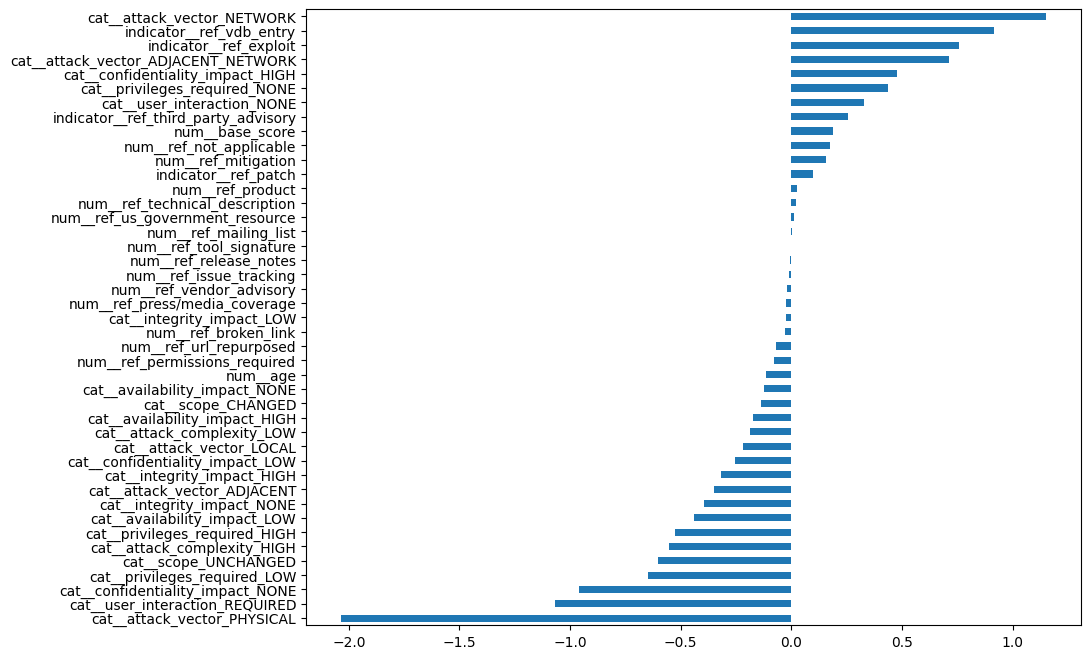

In [80]:
(pd.Series(lr.coef_[0], index=preprocessor.get_feature_names_out())
 .sort_values()
 .plot
 .barh(figsize=(10, 8))
)

In [71]:
print(classification_report(y_true=y_test, y_pred=lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75       833
           1       0.74      0.81      0.77       833

    accuracy                           0.76      1666
   macro avg       0.76      0.76      0.76      1666
weighted avg       0.76      0.76      0.76      1666



In [72]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.8379351740696278

In [73]:
print(classification_report(y_true=y_test, y_pred=xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       833
           1       0.81      0.88      0.84       833

    accuracy                           0.84      1666
   macro avg       0.84      0.84      0.84      1666
weighted avg       0.84      0.84      0.84      1666



## Interpretation

## Tuning

In [570]:
import optuna
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold


def optuna_randomized_search_clf(runs=20,
                                 model_class=None,
                                 X=None, 
                                 y=None):
    def objective(trial):
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

        model_params = {
            'n_estimators': trial.suggest_int('n_estimators', 1, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0, 1),
            'max_depth': trial.suggest_int('max_depth', 1, 100),
            #'gamma': trial.suggest_float('gamma', 0, 10),
            #'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            #'subsample': trial.suggest_float('subsample', 0, 1),
            #'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
            #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0, 1),
            #'colsample_bynode': trial.suggest_float('colsample_bynode', 0, 1),
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'random_state': 2
        }

        model = model_class(**model_params)

        scores = cross_val_score(model,
                                 X,
                                 y,
                                 cv=kfold,
                                 scoring='f1',
                                 n_jobs=-1)
        return scores.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=runs)

    # Extract best parameters
    best_params = study.best_params
    print("Best params:", best_params)
    print("Training score :", study.best_value)
    return best_params

In [571]:
model_class = XGBClassifier
best_params = optuna_randomized_search_clf(model_class=model_class, X=X_train, y=y_train, runs=100)

[I 2024-05-16 16:17:27,439] A new study created in memory with name: no-name-7517b42e-536f-419b-8d88-e1816936225a
[I 2024-05-16 16:17:28,543] Trial 0 finished with value: 0.8105219462460308 and parameters: {'n_estimators': 825, 'learning_rate': 0.6534651299014468, 'max_depth': 37}. Best is trial 0 with value: 0.8105219462460308.
[I 2024-05-16 16:17:29,020] Trial 1 finished with value: 0.8072963634675492 and parameters: {'n_estimators': 170, 'learning_rate': 0.7530595353271998, 'max_depth': 54}. Best is trial 0 with value: 0.8105219462460308.
[I 2024-05-16 16:17:29,600] Trial 2 finished with value: 0.8061309235538449 and parameters: {'n_estimators': 592, 'learning_rate': 0.7689720961566161, 'max_depth': 37}. Best is trial 0 with value: 0.8105219462460308.
[I 2024-05-16 16:17:30,102] Trial 3 finished with value: 0.8123712434605818 and parameters: {'n_estimators': 333, 'learning_rate': 0.9499879216996616, 'max_depth': 18}. Best is trial 3 with value: 0.8123712434605818.
[I 2024-05-16 16:1

Best params: {'n_estimators': 813, 'learning_rate': 0.8941745146542147, 'max_depth': 51}
Training score : 0.8184932981545169


In [572]:
xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)
print(classification_report(y_true=y_test, y_pred=xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       149
           1       0.80      0.86      0.83       148

    accuracy                           0.82       297
   macro avg       0.82      0.82      0.82       297
weighted avg       0.82      0.82      0.82       297



## Evaluation

* Confusion matrix
* Learning curve
* Precision/recall/f1/ROC
* Precision/recall curve

In [573]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def plot_roc_curve(y_true, y_scores, pos_label=1):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    lw = 2  # Line width
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

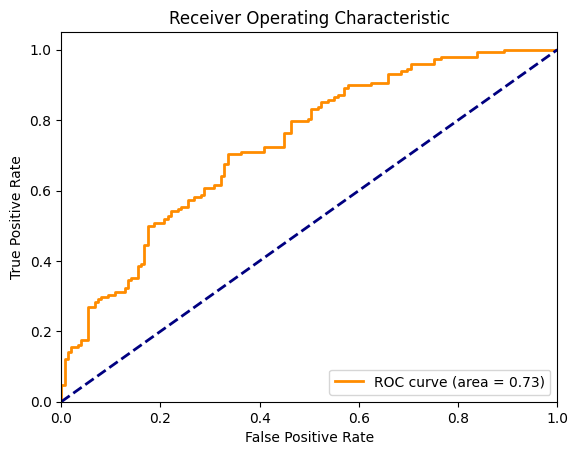

In [575]:
plot_roc_curve(y_true=y_test, y_scores=lr.predict_proba(X_test)[:, 1])

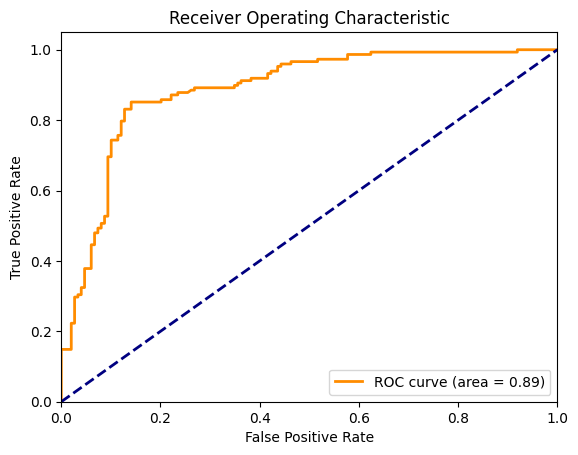

In [574]:
plot_roc_curve(y_true=y_test, y_scores=xgb.predict_proba(X_test)[:, 1])

In [454]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

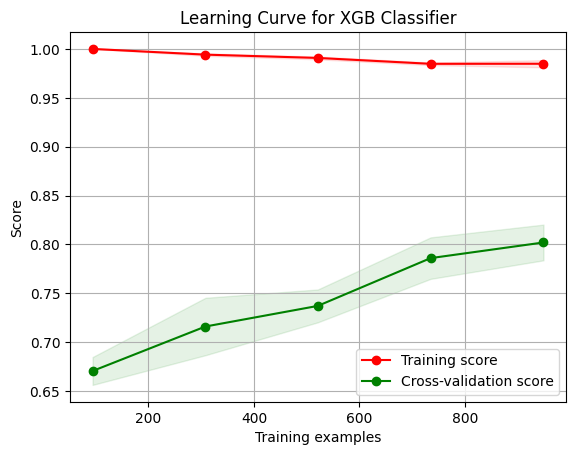

In [576]:
plot_learning_curve(XGBClassifier(**best_params), 'Learning Curve for XGB Classifier', X_train, y_train, cv=5, n_jobs=-1)

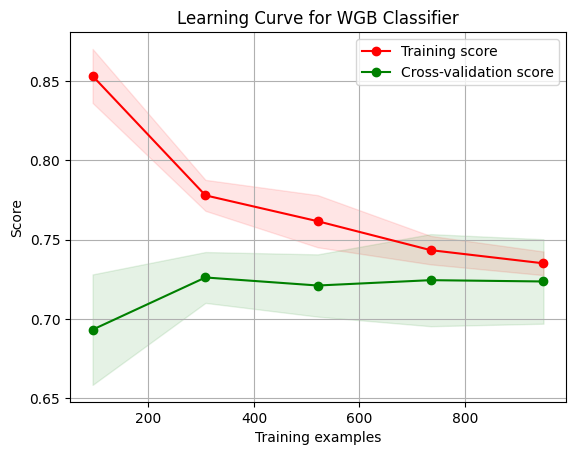

In [577]:
plot_learning_curve(LogisticRegression(max_iter=10000), 'Learning Curve for WGB Classifier', X_train, y_train, cv=5, n_jobs=-1)
